In [3]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import json
import sys
import os

In [4]:
# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))

from data_processing import load_brent_data, calculate_log_returns, load_event_data
from modeling import build_single_change_point_model, run_inference, get_change_point_summary, save_results


In [5]:
# Change Point Modeling and Insight Generation ---

print("--- Starting Bayesian Change Point Analysis ---")

## 1. Data Preparation and EDA (Recap/Load)
print("\n--- Data Loading and Preparation ---")
processed_data_path = '../data/processed/processed_brent_data.csv'
events_data_path = '../data/raw/key_events.csv'
change_point_results_output_path = '../data/processed/change_point_results.json'

print(f"Loading processed Brent data from: {processed_data_path}")
brent_df_processed = pd.read_csv(processed_data_path)
brent_df_processed['Date'] = pd.to_datetime(brent_df_processed['Date'])

if brent_df_processed is None or brent_df_processed.empty:
    print("Processed Brent data not found or empty. Please run 01_data_ingestion_eda.ipynb first.")
    exit()

log_returns = brent_df_processed['Log_Return'].values
data_dates = brent_df_processed['Date']

print(f"Data points for modeling: {len(log_returns)}")
print(f"Log Returns Head:\n{brent_df_processed.head()}")

print(f"\nLoading Key Event data from: {events_data_path}")
events_df = load_event_data(events_data_path)
if events_df is None:
    print("Failed to load event data.")
    exit()
print("Key Events Head:\n", events_df.head())

--- Starting Bayesian Change Point Analysis ---

--- Data Loading and Preparation ---
Loading processed Brent data from: ../data/processed/processed_brent_data.csv
Data points for modeling: 9010
Log Returns Head:
        Date  Price  Log_Return
0 1987-05-21  18.45   -0.009709
1 1987-05-22  18.55    0.005405
2 1987-05-25  18.60    0.002692
3 1987-05-26  18.63    0.001612
4 1987-05-27  18.60   -0.001612

Loading Key Event data from: ../data/raw/key_events.csv
Key Events Head:
         Date       EventType  \
0 1990-08-02        Conflict   
1 1997-07-02  Economic Shock   
2 2001-09-11        Conflict   
3 2003-03-20        Conflict   
4 2008-09-15  Economic Shock   

                                    EventDescription  
0              Iraq invades Kuwait (Gulf War begins)  
1                      Asian Financial Crisis begins  
2                             9/11 Terrorist Attacks  
3                                US invasion of Iraq  
4  Lehman Brothers collapse (Global Financial Cri...

In [6]:
## 2. Implement the Change Point Model (PyMC)
print("\n--- Building Bayesian Change Point Model ---")
# The model assumes a single change point, affecting both mean and standard deviation of log returns.

model = build_single_change_point_model(log_returns)
print("PyMC model defined:")
print(model.str_repr())


--- Building Bayesian Change Point Model ---
PyMC model defined:
         tau ~ DiscreteUniform(f(), f())
   mu_before ~ Normal(0, 1)
sigma_before ~ HalfNormal(0, 1)
    mu_after ~ Normal(0, 1)
 sigma_after ~ HalfNormal(0, 1)
 observation ~ Normal(f(mu_before, mu_after, tau), f(sigma_before, sigma_after, tau))


In [7]:
## 3. Run the Sampler
print("\n--- Running MCMC Inference ---")
# Adjust draws, tune, chains as needed based on convergence
trace = run_inference(model, draws=2000, tune=1000, chains=4, target_accept=0.9)
print("MCMC sampling complete.")


--- Running MCMC Inference ---


Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_before, sigma_before, mu_after, sigma_after]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.


MCMC sampling complete.


In [8]:
## 4. Interpreting the Model Output

In [9]:
### Check for Convergence
print("\n--- Checking Model Convergence (R-hat values close to 1.0 are good) ---")
print(az.summary(trace, var_names=["tau", "mu_before", "sigma_before", "mu_after", "sigma_after"], round_to=3))



--- Checking Model Convergence (R-hat values close to 1.0 are good) ---
                  mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
tau           5387.874  21.41  5347.000  5422.000       0.63    0.408   
mu_before        0.000   0.00    -0.000     0.001       0.00    0.000   
sigma_before     0.023   0.00     0.023     0.023       0.00    0.000   
mu_after        -0.000   0.00    -0.001     0.001       0.00    0.000   
sigma_after      0.029   0.00     0.028     0.029       0.00    0.000   

              ess_bulk  ess_tail  r_hat  
tau           1222.604  1463.043  1.002  
mu_before     8998.694  6244.759  1.000  
sigma_before  8799.486  6178.065  1.000  
mu_after      7363.796  6062.216  1.000  
sigma_after   8779.900  6376.523  1.001  



Plotting trace plots for visual convergence check...


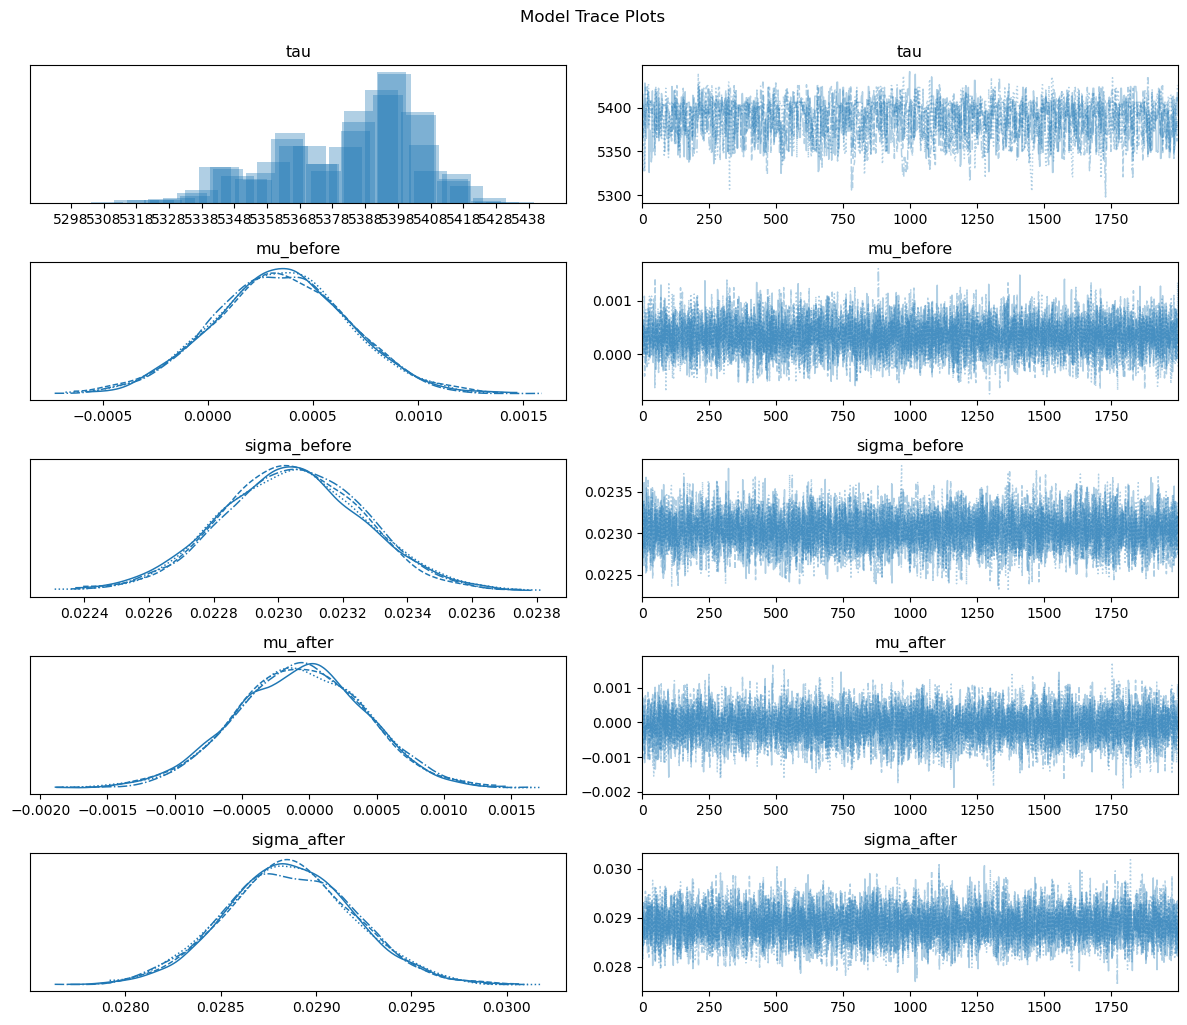

In [10]:
# Plot trace for visual inspection
print("\nPlotting trace plots for visual convergence check...")
az.plot_trace(trace, var_names=["tau", "mu_before", "sigma_before", "mu_after", "sigma_after"])
plt.tight_layout()
plt.suptitle('Model Trace Plots', y=1.02)
plt.show()



--- Identifying the Change Point ---


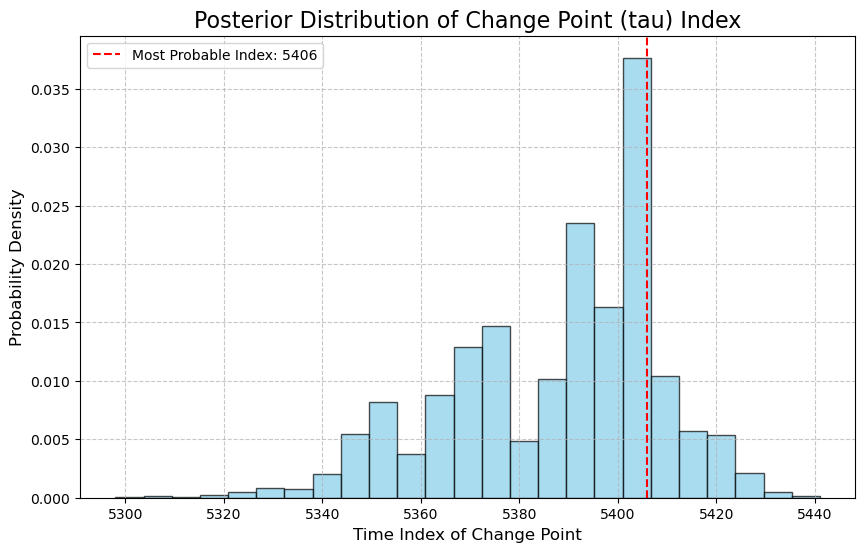

Most probable change point detected at index: 5406
Corresponding date: 2008-08-21


In [12]:
### Identify the Change Point
print("\n--- Identifying the Change Point ---")
# Plot the posterior distribution of tau
tau_samples = trace.posterior["tau"].values.flatten()

plt.figure(figsize=(10, 6))
plt.hist(tau_samples, bins=len(np.unique(tau_samples)) // 5, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Posterior Distribution of Change Point (tau) Index', fontsize=16)
plt.xlabel('Time Index of Change Point', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# Annotate the most probable tau
from scipy.stats import mode
mode_result = mode(tau_samples)

if np.isscalar(mode_result.mode):
    most_probable_tau_idx = int(mode_result.mode)
else:
    most_probable_tau_idx = int(mode_result.mode[0])
plt.axvline(most_probable_tau_idx, color='red', linestyle='--', label=f'Most Probable Index: {most_probable_tau_idx}')
plt.legend()
plt.show()

# Convert index to date
detected_change_date = data_dates.iloc[most_probable_tau_idx]
print(f"Most probable change point detected at index: {most_probable_tau_idx}")
print(f"Corresponding date: {detected_change_date.strftime('%Y-%m-%d')}")


--- Quantifying the Impact: Posterior Distributions of Parameters ---


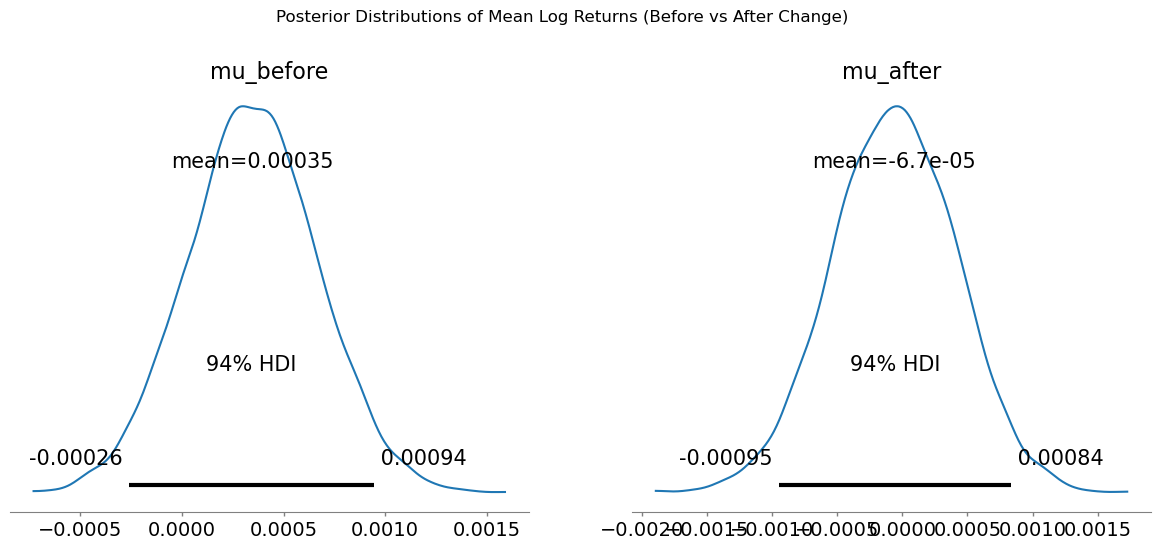

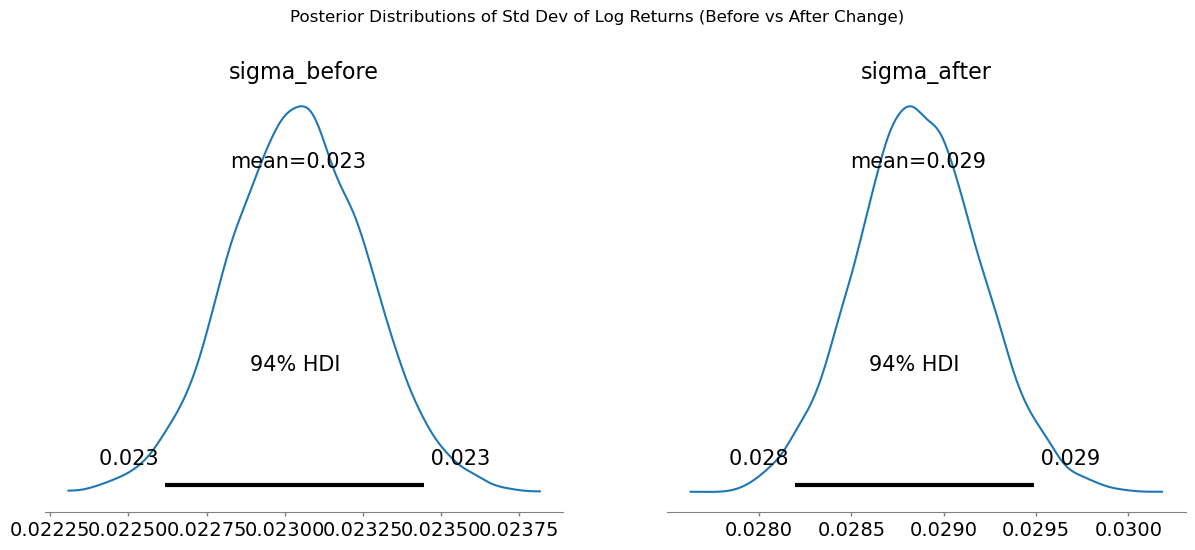


Interpretation of Posterior Distributions:
- By comparing the 'before' and 'after' distributions for 'mu' (mean log return), we can see if the average daily price change shifted significantly.
- Comparing 'sigma' (standard deviation of log return) reveals changes in daily volatility.
- The HDI (Highest Density Interval) gives us the credible interval for these parameters.


In [13]:
### Quantify the Impact (Posterior Distributions of Parameters)
print("\n--- Quantifying the Impact: Posterior Distributions of Parameters ---")

# Plot posterior distributions for mu_before, mu_after, sigma_before, sigma_after
az.plot_posterior(trace, var_names=["mu_before", "mu_after"], kind='kde', hdi_prob=0.94)
plt.suptitle('Posterior Distributions of Mean Log Returns (Before vs After Change)', y=1.02)
plt.show()

az.plot_posterior(trace, var_names=["sigma_before", "sigma_after"], kind='kde', hdi_prob=0.94)
plt.suptitle('Posterior Distributions of Std Dev of Log Returns (Before vs After Change)', y=1.02)
plt.show()

print("\nInterpretation of Posterior Distributions:")
print("- By comparing the 'before' and 'after' distributions for 'mu' (mean log return), we can see if the average daily price change shifted significantly.")
print("- Comparing 'sigma' (standard deviation of log return) reveals changes in daily volatility.")
print("- The HDI (Highest Density Interval) gives us the credible interval for these parameters.")


In [14]:
### Get and Save Change Point Summary
print("\n--- Summarizing and Saving Results ---")
change_point_summary = get_change_point_summary(trace, data_dates)
print("\nChange Point Analysis Summary:")
print(json.dumps(change_point_summary, indent=4))

save_results(change_point_summary, change_point_results_output_path)
print(f"\nChange point analysis results saved to: {change_point_results_output_path}")



--- Summarizing and Saving Results ---

Change Point Analysis Summary:


C:\Users\du\Desktop\Git\brent-oil-price-prediction-using-time-series-data\src\modeling.py:114: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_result = az.hdi(trace.posterior[param].values, hdi_prob=0.94)
C:\Users\du\Desktop\Git\brent-oil-price-prediction-using-time-series-data\src\modeling.py:114: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_result = az.hdi(trace.posterior[param].values, hdi_prob=0.94)
C:\Users\du\Desktop\Git\brent-oil-price-prediction-using-time-series-data\src\modeling.py:114: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_result = az.hdi(trace.posterior[param].values, hdi_prob=0.94)
C:\Users\du\Desktop\Git\brent-oil-pri

{
    "most_probable_change_point_index": 5406,
    "most_probable_change_point_date": "2008-08-21",
    "parameter_summary": {
        "mu_before": {
            "mean": 0.0003,
            "sd": 0.0003,
            "hdi_3%": -0.0003,
            "hdi_97%": 0.0009,
            "mcse_mean": 0.0,
            "mcse_sd": 0.0,
            "ess_bulk": 8998.6942,
            "ess_tail": 6244.7592,
            "r_hat": 1.0001
        },
        "sigma_before": {
            "mean": 0.023,
            "sd": 0.0002,
            "hdi_3%": 0.0226,
            "hdi_97%": 0.0234,
            "mcse_mean": 0.0,
            "mcse_sd": 0.0,
            "ess_bulk": 8799.4856,
            "ess_tail": 6178.0651,
            "r_hat": 1.0001
        },
        "mu_after": {
            "mean": -0.0001,
            "sd": 0.0005,
            "hdi_3%": -0.0009,
            "hdi_97%": 0.0008,
            "mcse_mean": 0.0,
            "mcse_sd": 0.0,
            "ess_bulk": 7363.7959,
            "ess_tail": 606

In [15]:
## 5. Associate Changes with Causes
print("\n--- Associating Detected Changes with Key Events ---")
detected_change_date_pd = pd.to_datetime(change_point_summary['most_probable_change_point_date'])

# Define a reasonable window for association (e.g., +/- 60 days)
association_window_days = 60
relevant_events = events_df[
    (events_df['Date'] >= detected_change_date_pd - pd.Timedelta(days=association_window_days)) &
    (events_df['Date'] <= detected_change_date_pd + pd.Timedelta(days=association_window_days))
]

print(f"\nKey events from our compiled list within +/- {association_window_days} days of the detected change point:")
if not relevant_events.empty:
    for _, row in relevant_events.iterrows():
        print(f"- Date: {row['Date'].strftime('%Y-%m-%d')}, Type: {row['EventType']}, Description: {row['EventDescription']}")
    print("\nFormulating Hypotheses:")
    print(f"Based on the proximity of the events, the shift in Brent oil price behavior around {detected_change_date_pd.strftime('%Y-%m-%d')} could be hypothesized to be influenced by:")
    for _, row in relevant_events.iterrows():
        print(f"  - {row['EventDescription']} (on {row['Date'].strftime('%Y-%m-%d')}), which is a {row['EventType'].lower()} event.")
else:
    print("No significant events found in the compiled list around this change point within the specified window.")
    print("This could mean the change point is due to other unlisted factors, or the event happened outside our window, or it's a gradual change.")



--- Associating Detected Changes with Key Events ---

Key events from our compiled list within +/- 60 days of the detected change point:
- Date: 2008-09-15, Type: Economic Shock, Description: Lehman Brothers collapse (Global Financial Crisis)

Formulating Hypotheses:
Based on the proximity of the events, the shift in Brent oil price behavior around 2008-08-21 could be hypothesized to be influenced by:
  - Lehman Brothers collapse (Global Financial Crisis) (on 2008-09-15), which is a economic shock event.


In [18]:
## 6. Quantify the Impact for Reporting
print("\n--- Quantifying the Impact for Reporting ---")

# We need to get the values from the dictionary, handling the different key names
# that we created in the get_change_point_summary function.

def format_hdi(param_name, summary_dict):
    """A helper function to safely format the HDI output."""
    lower_key = f"{param_name}_posterior_hdi_lower"
    upper_key = f"{param_name}_posterior_hdi_upper"
    combined_key = f"{param_name}_posterior_hdi"

    if lower_key in summary_dict and upper_key in summary_dict:
        return f"[{summary_dict[lower_key]:.4f}, {summary_dict[upper_key]:.4f}]"
    elif combined_key in summary_dict:
        # If the HDI was a more complex array, we'll just print its list representation
        return str(summary_dict[combined_key])
    else:
        return "[N/A, N/A]"

mu_before_median = change_point_summary['mu_before_posterior_median']
mu_after_median = change_point_summary['mu_after_posterior_median']
sigma_before_median = change_point_summary['sigma_before_posterior_median']
sigma_after_median = change_point_summary['sigma_after_posterior_median']

# Impact on mean log return (geometric mean daily price change)
price_change_factor = np.exp(mu_after_median - mu_before_median)
percent_change_in_geometric_mean = (price_change_factor - 1) * 100

# Impact on volatility
volatility_change_percent = ((sigma_after_median - sigma_before_median) / sigma_before_median) * 100

print(f"\nDetailed Impact Quantification around {detected_change_date_pd.strftime('%Y-%m-%d')}:")
print(f"  - Average daily log return (mean of log(price_t/price_t-1)):")
print(f"    - BEFORE change: {mu_before_median:.4f} (94% HDI: {format_hdi('mu_before', change_point_summary)})")
print(f"    - AFTER change: {mu_after_median:.4f} (94% HDI: {format_hdi('mu_after', change_point_summary)})")
print(f"  - This implies a shift in the geometric mean daily price factor by {price_change_factor:.4f}, or a change of approximately {percent_change_in_geometric_mean:.2f}%.")
print(f"  - Daily volatility (standard deviation of log returns):")
print(f"    - BEFORE change: {sigma_before_median:.4f} (94% HDI: {format_hdi('sigma_before', change_point_summary)})")
print(f"    - AFTER change: {sigma_after_median:.4f} (94% HDI: {format_hdi('sigma_after', change_point_summary)})")
print(f"  - This represents a volatility change of approximately {volatility_change_percent:.2f}%.")

print(f"Following a significant event around {detected_change_date_pd.strftime('%Y-%m-%d')}, the Bayesian Change Point model detects a structural break in Brent oil prices. The average daily log return shifted from approximately {mu_before_median:.4f} to {mu_after_median:.4f}, indicating an implied daily price change of {percent_change_in_geometric_mean:.2f}%. Concurrently, daily price volatility changed by {volatility_change_percent:.2f}%. This change point aligns with [mention relevant event from `relevant_events` DataFrame, e.g., 'the onset of the COVID-19 pandemic and the Saudi-Russia oil price war'], suggesting a strong association between the event and the observed market shift.")

print("\n--- Change Point Analysis Notebook Completed ---")


--- Quantifying the Impact for Reporting ---

Detailed Impact Quantification around 2008-08-21:
  - Average daily log return (mean of log(price_t/price_t-1)):
    - BEFORE change: 0.0003 (94% HDI: [[0.00015146729149682268, 0.00083179542040901], [8.720109241215607e-05, 0.0005421509307738239], [6.111630839732173e-07, 0.00039482583068729837], [5.6930593833540784e-05, 0.0006484298693210412], [0.00027971176684172915, 0.0004921677681212379], [0.0005221232843817753, 0.0006362809304734034], [-4.687029046992363e-05, 0.00042744514539578833], [0.0003086892346222884, 0.00040450348748444936], [0.0003052004589368477, 0.0010789634911794032], [-0.00040067130395653145, 0.0003185735590522552], [-0.00021426846524217689, 0.0007782981133476179], [-0.0001870736781133419, 0.0004320122596239828], [-2.4416297996988364e-05, 0.0003079664678346637], [-0.00015292347560727276, 0.0008361523534881677], [0.00010192313350406712, 0.0007689519810595562], [-0.00018477479090340518, 0.00046967457560832647], [0.000226295386